# Prédire l'interaction molécule - protéine pour la découverte de médicaments
Rachid Sahli - rachidsahli144@outlook.fr

### Import des données 

In [1]:
# !pip install rdkit
# !pip install py3Dmol

# Import librairies ----
## Algèbre linéaire et manipulation de données
import numpy as np
import pandas as pd

# Viasualisaton moléculaire
import py3Dmol

## RDKit
import rdkit 
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import Draw

## Machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate

In [2]:
# Import data ----
train = pd.read_csv('data/x_train.csv')
test = pd.read_csv('data/x_test.csv')

y_train = pd.read_csv('data/y_train.csv')['y']

print(f"Le dataset d'entraînement contient {train.shape[0]} molécules.")
print(f"le dataset de test contient {test.shape[0]} molécules.")

train.head()

Le dataset d'entraînement contient 4400 molécules.
le dataset de test contient 2934 molécules.


,id,smiles
0,0,CNC(=O)c1ccccc1Sc1ccc2c(C#Cc3cccc(NCCOC)c3)n[n...
1,1,CC(C)(C)c1ccc(Nc2nnc(-c3cnccc3CCc3ccncc3)o2)cc1
2,2,CN1CCN(CCCn2ccc(-c3cnc4c(-c5ccsc5)cnn4c3)cc2=O...
3,3,CCn1c2ccc(NC(=O)Nc3ccc(OC)cc3)cc2c2c3c(c4c(c21...
4,4,Cc1ccc(C(=O)Nc2cccc(C(C)C)c2)cc1N1CCc2ncncc2C1


Les molécules sont au format SMILES. Afin de pouvoir les manipuler avec la librairie rdkit, nous les convertissons au format
'Mol'

In [3]:
# Convertion
train_mols = [AllChem.MolFromSmiles(smile) for smile in train['smiles']]
test_mols = [AllChem.MolFromSmiles(smile) for smile in test['smiles']]

print(type(train_mols[0]))

<class 'rdkit.Chem.rdchem.Mol'>


### Visualisation des molécules

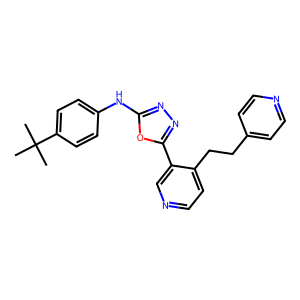

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:
index = 1  # Index de la molécule
mol = train_mols[index]
img = Draw.MolToImage(mol)
display(img) # Affichage de la molécule

# Affichage en 3D
view = py3Dmol.view(width=450, height=400)
mol = train_mols[index]  
mol_block = Chem.MolToMolBlock(mol)
view.addModel(mol_block, "mol")
view.setStyle({"stick": {}})
view.zoomTo()
view.show()

### Calcul des empreintes moléculaires (fingerprints)

Les fingerprints sont des vecteurs binaires qui capturent la présence ou l'absence de caractéristiques chimiques spécifiques, telles que les groupes fonctionnels, les types d'atomes, les liaisons ou les propriétés moléculaires. C'est une manière courante d'encoder l'information contenue dans une molécule. On convertit donc nos molécules intialement stockées au format SMILES en fingerprints. 

In [5]:
# Convertion de Mol à Fingerprints
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
train_fps = np.array([morgan_gen.GetFingerprint(mol) for mol in train_mols])
test_fps = np.array([morgan_gen.GetFingerprint(mol) for mol in test_mols])

print(f"Le dataset d'entraînement contient {train_fps.shape[0]} molécules encodées avec {train_fps.shape[1]} bits.")
print(f"Le  dataset de test contient {test_fps.shape[0]} molécules encodées avec  {test_fps.shape[1]} bits.")

Le dataset d'entraînement contient 4400 molécules encodées avec 2048 bits.
Le  dataset de test contient 2934 molécules encodées avec  2048 bits.


Nos deux jeux de données contiennent à présent des molécules qui sont des vecteurs binaires de 2048 bits chacun.

In [6]:
pd.DataFrame(train_fps).head()
pd.DataFrame(test_fps).head() 

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Machine learning

Maintenant, que nous disposons des données, nous pouvons entraîner des modèles d'apprentissage sur celle-ci.